# Projekt Voki: vocabulary cards extraction

## Imports

In [1]:
import json
import fitz
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from copy import deepcopy
import cv2
import numpy as np
import pandas as pd
import hashlib
import re

%matplotlib inline

## Functions

In [2]:
def myimshow(im,h=12,w=8):
    plt.figure(figsize=(w,h))
    plt.imshow(im)
    plt.show()
    
def gridshow(imgs,h=12,w=8):
    n=len(imgs)    
    fig, axes = plt.subplots(nrows=1, ncols=n, sharey='row', figsize=(h*n, h*2))
    for j, ax in enumerate(axes):
        ax.imshow(imgs[j])
        ax.set_xticks([])
        ax.set_yticks([])
    
def getpage(data,n):
    if n<0:
        raise Exception(f'n ({n}) must be 0 or larger')
    if n< len(data['analyze_result']['read_results']): 
        return data['analyze_result']['read_results'][n]
    else: raise Exception(f"n ({n}) must be smaller than the number of pages ({len(data['analyze_result']['read_results'])})")
    
def box_to_polygon(box,w_inch,h_inch,w_pix,h_pix):
    box = np.array(box)
    return np.array([[x,y] for x,y, in zip(box[::2]/w_inch*w_pix,box[1::2]/h_inch*h_pix)])

def rotate_image(image, angle, center):
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def rotate_point(p,alpha,p0):
    x = p[0]
    y = -p[1]
    x0 = p0[0]
    y0 = -p0[1]
    x1 = (x-x0)*np.cos(np.deg2rad(alpha)) - (y-y0)*np.sin(np.deg2rad(alpha)) + x0
    y1 = (x-x0)*np.sin(np.deg2rad(alpha)) + (y-y0)*np.cos(np.deg2rad(alpha)) + y0
    return np.array([x1,-y1])

def rotate_polygon(polygon,angle,center):
    result = []
    for p in polygon:
        result.append(rotate_point(p,angle,center))
    return np.array(result)



## get pdf and json files

In [3]:
root = Path.cwd()
root

fname_json = root.parent /'data/serievertes2.json'
fname_pdf = root.parent /'data/Scan_01-12-2021_1728.pdf' 

with open(fname_json,'r') as fh:
    data_raw=json.load(fh)

image_list=[]
zoom = 2 # to increase the resolution
mat = fitz.Matrix(zoom, zoom)
doc = fitz.open(fname_pdf)
for page in doc:
    pix = page.get_pixmap(matrix = mat)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    image_list.append(img)
 

### create images with boxes for visualization purpose

In [4]:

results=[]
for i, image in enumerate(image_list):
    data = getpage(data_raw,i)
    w_inch=data['width']
    h_inch=data['height']
    im=deepcopy(image)
    im = np.array(im) 
    im = im[:, :, ::-1].copy()
    angle = data['angle']
    h_pix ,w_pix,_ = im.shape
    image_center = (h_pix/2,w_pix/2)
    im_rotated = rotate_image(im, angle, image_center)
    im = rotate_image(im, angle, image_center)
    
    line_polygons=[]
    word_polygons=[]
    
    for line in data['lines']:
        # add line info
        line_polygon = box_to_polygon(line['bounding_box'],w_inch,h_inch,w_pix,h_pix)
        line_polygon = rotate_polygon(line_polygon,angle,image_center)
        line_polygon = np.round(line_polygon).astype(int)
        im=cv2.polylines(im, [line_polygon], True, (0,255,0), thickness=3)
        line_polygons.append(line_polygon)

        #add word info
        for word in line['words']:
            word_polygon = box_to_polygon(word['bounding_box'],w_inch,h_inch,w_pix,h_pix)
            word_polygon = rotate_polygon(word_polygon,angle,image_center)
            word_polygon = np.round(word_polygon).astype(int)
            
            #im=cv2.polylines(im, [word_polygon], True, (255,0,0), thickness=2)
            word_polygons.append(word_polygon)
            
    page_result= {
        'im':im,
        'im_raw':im_rotated,
        'w_inch':w_inch,
        'h_inch':h_inch,
        'h_pix':h_pix,
        'w_pix':w_pix,
        'line_polygons':line_polygons,
        'word_polygons':word_polygons
        
    }
    results.append(page_result)
    

### plot those pages

In [ ]:
n = 2# number of images in one row
h = 9
plot_images=[]
for i,result in enumerate(results[:10]):
    
    plot_images.append(result['im'])
    if i%n == n-1:
        fig, axes = plt.subplots(nrows=1, ncols=n, sharey='row', figsize=(h*n, h*2))
        for j, ax in enumerate(axes):
            
            ax.imshow(plot_images[j])
        plot_images=[]
        
        
    

## figure out page column parameters

In [6]:
i=0
im = deepcopy(results[i]['im'])
page_height,page_width,n_channels = im.shape
line_thickness = 2

props = {'left': 
         {'x':[170,260,5000],
          'col':(0, 128, 128)},
         'right':
         {'x':[750,850,1050],
          'col':(128, 0, 128)},
         'center':
         {'x':[410,500,850],
          'col':(128, 128, 128)}
        }

canvas_start = (170,100)
canvas_end = (1050,1300)
canvas_color = (0,0,128)

labels = ['french','german','sentence']
delta_median = 10 

im = cv2.rectangle(im, canvas_start, canvas_end, (200,200,0), line_thickness)

for prop,vals in props.items():
    for x in vals['x']:
        # im = cv2.line(im, (x, canvas_start[1]), (x, canvas_end[1]), vals['col'], thickness=line_thickness)
        im = cv2.line(im, (x, canvas_start[1]), (x, canvas_end[1]), vals['col'], thickness=line_thickness)
im_boxes = deepcopy(im)
# myimshow(im)

## create tabular Dataframe of Lines

In [7]:
def add_alpha_rectangle(src,pos,alpha=0.75,col=[255,0,0]):
    # ... to an image at place pos
    x_min, x_max, y_min, y_max = pos
    sub_img = src[y_min:y_max, x_min:x_max]
    s=sub_img.shape
    blend_vec = np.array(col,dtype=np.uint8)
    blend_mat = np.tile(blend_vec,(s[0],s[1],1))
    res = cv2.addWeighted(sub_img, alpha, blend_mat, 1-alpha, 0)
    src[y_min:y_max, x_min:x_max] = res
    return src



def apply_vertical_thresholds(df,props):
    # position based
    left_edge_start = df['x_min'] > props['x'][0]
    left_edge_end = df['x_min'] < props['x'][1]
    right_edge = df['x_max'] < props['x'][2]
    return left_edge_start & left_edge_end & right_edge

def identify_french_voki(df,props):
    df['french'] = apply_vertical_thresholds(df,props)
    # remove individual words
    bad_words = ['Exercices','Vocabulaire']
    df = df.drop(df[df['text'].isin(bad_words)].index)
    return df

def identify_german_voki(df,props):
    df['german'] = apply_vertical_thresholds(df,props)
    return df
    
def identify_sentence(df,props):
    df['sentence'] = apply_vertical_thresholds(df,props)
    return df

def clean_df_1(df):
    bad_texts = ['VOCABULAIRE']
    df = df[~df['text'].isin(bad_texts)]
    return df

In [8]:
show_pages = 45

dfs=[]
for i, (image,data_processed) in enumerate(zip(image_list,results)):
    # get data for one page
    data = getpage(data_raw,i)
#     w_inch=data['width']
#     h_inch=data['height']
    im = data_processed['im']
    h_pix ,w_pix,_ = im.shape
    
    # go through all lines and record the coordinates
    for j,line in enumerate(data['lines']):
        df_dict = {}
        box_points = data_processed['line_polygons'][j]
        x_min = np.min(box_points[:,0])
        x_max = np.max(box_points[:,0])
        y_min = np.min(box_points[:,1])
        y_max = np.max(box_points[:,1])
        df_dict = {'text': [line['text']],
                   'x_min' : [x_min],
                   'x_max': [x_max],
                   'y_min': [y_min],
                   'y_max': [y_max],
                   'height': [y_max - y_min],
                   'width': [x_max - x_min],
                   'confidence': [line['appearance']['style']['confidence']],
                   'polygone': [box_points],
                   'word_texts': [[word['text'] for word in line['words']]],
                   'word_confidences': [[word['confidence'] for word in line['words']]],
                   'page': [data['page']],
                   'page_angle': [data['angle']], 
                   'words':[line['words']],
                   }
        dfs.append(pd.DataFrame(df_dict))
        
df = pd.concat(dfs).reset_index(drop=True)
df["id"] = df.index

# identify right column / french words
df = df[df['text'].str.len()>1] # single chars
# df = df[df['width']<400] # too long lines
df = df[df['y_max']<canvas_end[1]]
df = identify_french_voki(df,props['left']) 
df = identify_german_voki(df,props['right']) 
df = identify_sentence(df,props['center']) 
df['label']=df[labels].dot(df[labels].columns)
# df = clean_df_1(df)


#check that no field was double labeled
print('unique language check')
print(df[['french','german','sentence']].sum(axis=1).value_counts())
df.head()
    



unique language check
1    3490
0     467
dtype: int64


,text,x_min,x_max,y_min,y_max,height,width,confidence,polygone,word_texts,word_confidences,page,page_angle,words,id,french,german,sentence,label
0,VOCABULAIRE,703,944,62,98,36,241,0.878,"[[703, 62], [944, 62], [944, 98], [703, 98]]",[VOCABULAIRE],[0.994],1,0.0,"[{'bounding_box': [4.8934, 0.4311, 6.5317, 0.4...",0,False,False,False,
2,le jaune,196,264,113,135,22,68,0.878,"[[196, 113], [264, 113], [264, 135], [196, 135]]","[le, jaune]","[0.996, 0.996]",1,0.0,"[{'bounding_box': [1.3689, 0.7976, 1.4551, 0.7...",2,True,False,False,french
3,- jaune,441,515,116,137,21,74,0.878,"[[441, 116], [515, 116], [515, 135], [441, 137]]","[-, jaune]","[0.979, 0.996]",1,0.0,"[{'bounding_box': [3.0718, 0.8192, 3.1581, 0.8...",3,False,False,True,sentence
4,das Gelb,782,854,118,135,17,72,0.878,"[[782, 118], [854, 118], [854, 135], [782, 135]]","[das, Gelb]","[0.994, 0.994]",1,0.0,"[{'bounding_box': [5.4431, 0.8192, 5.594, 0.81...",4,False,True,False,german
5,ou alors,197,267,138,157,19,70,0.878,"[[197, 138], [267, 138], [267, 157], [197, 157]]","[ou, alors]","[0.994, 0.996]",1,0.0,"[{'bounding_box': [1.3689, 0.9593, 1.509, 0.95...",5,True,False,False,french


## make images with language labels

In [9]:
delta_median = 10

label_colors = [[255,0,0],
                [0,0,255],
                [0,255,0]]

extension_colors =  [[255,150,150],
                    [150,150,255],
                    [150,255,150]]

labels = ['french','german','sentence']

for i, result in enumerate(results):
    # get data for one page
    im=deepcopy(result['im_raw'])
    
    # add canvas info
    line_thickness = 2
    im = cv2.rectangle(im, canvas_start, canvas_end, canvas_color, line_thickness)
    for prop,vals in props.items():
        for x in vals['x']:
            im = cv2.line(im, (x, canvas_start[1]), (x, canvas_end[1]), (200,200,0), thickness=line_thickness)
        
    df_page = df[df['page']== i+1]
    
    # add median start values
    page_medians={}
    for label in labels:
        median_xmin = np.round(df_page[df_page[label]]['x_min'].median()).astype(int)
        page_medians[label]=median_xmin
        im = cv2.line(im, (median_xmin, canvas_start[1]), (median_xmin, canvas_end[1]), (200,0,200), thickness=line_thickness)
        im = cv2.line(im, (median_xmin+delta_median, canvas_start[1]), 
                          (median_xmin+delta_median, canvas_end[1]), 
                          (200,100,200), thickness=line_thickness)
        
    # add langage labels
    for j, row in df_page.iterrows():
        for k, label in enumerate(labels):
            if row[label]:
                if row['x_min'] < page_medians[label]+delta_median:
                    color = label_colors[k]
                else:
                    color = extension_colors[k]
                im = add_alpha_rectangle(im, 
                                         [row['x_min'],row['x_max'],row['y_min'],row['y_max']],
                                         col=color)
            if row['label']=='':
                im = add_alpha_rectangle(im, 
                                         [row['x_min'],row['x_max'],row['y_min'],row['y_max']],
                                         col=(50,50,50))
                pass
    results[i]['im_language_labels'] = im


### plot those images

In [ ]:
for result in results:
    myimshow(result['im_language_labels'])

## adjust for intented phrases

In [10]:
def undo_linebreak(row,dF,append_counter):
    delta_y = 20 # empirically measured
    if not abs(row['y_min'] - dF.iloc[0]['y_min'] - append_counter*delta_y) < 15:
        return dF
    
    text = dF.iloc[0]['text']
    if text.endswith('-'):
        dF['text'] = [''.join([text.strip('-'),row['text']])]
    else:
        dF['text'] = [' '.join([text,row['text']])]
    dF['polygone'] = [np.append(dF.iloc[0]['polygone'],row['polygone'],axis=0)]
    dF['word_texts'] = [deepcopy_extend_lists(dF.iloc[0]['word_texts'],row['word_texts'])]
    dF['words'] = [deepcopy_extend_lists(dF.iloc[0]['words'],row['words'])]
    dF['word_confidences'] = [deepcopy_extend_lists(dF.iloc[0]['word_confidences'],row['word_confidences'])]
    dF['line_appended'] = [True]
    return dF

def deepcopy_extend_lists(a,b):
    c=a.copy()
    d=b.copy()
    c.extend(d)
    return c


pd.set_option('mode.chained_assignment', None)
delta_y_linebreak = 18 # pixel

dfs = []
for i, pagenum in enumerate(df.page.unique()):
# checkout that page's data
#     if i !=1:continue
    df_temp = df[df['page']==pagenum]

    # sort and make per label df
    df_temp = df_temp.sort_values(by=['y_max','label'])
    df_labels = {label:df_temp[df_temp['label']==label] for label in labels}


    page_medians = {}
    # get median values
    df_page_new=[]
    for label in labels:
#         if label !='german':continue
        median_xmin = np.round(df_labels[label]['x_min'].median()).astype(int)
        page_medians[label]=median_xmin

        result_rows = []
        append_counter = 0
        for j, row in df_labels[label].iterrows():
            
            if row['x_min'] > median_xmin + delta_median:
                append_counter +=1
#                 print(j,row['y_min'],append_counter,row['text'])
#                 if j==142:break
                try:
                    
                    result_rows[-1] = undo_linebreak(row, result_rows[-1],append_counter)
#                     print(f'reult_row: {result_rows[-1]["text"].values[0]}')
                except IndexError as e:
#                     print(e)
                    pass
#                     print(f'i: {i}, page {pagenum}, label {label}, j: {j}, text: {row["text"]}')
#                     print(e)
            else:
                append_counter = 0
                try:
                    result_rows.append(pd.DataFrame(row).transpose())
                except ValueError as e:
                    pass
#                     print(f'i: {i}, page {pagenum}, label {label}, j: {j}, text: {row["text"]}')
#                     print(e)
        try:
            df_page_new.append(pd.concat(result_rows))
        except ValueError as e:
            pass
#             print(f'i: {i}, page {pagenum}, label {label}, j: {j}, text: {row["text"]}')
#             print(e)

    dfs.append(pd.concat(df_page_new))
pd.set_option('mode.chained_assignment', 'raise')
df_6 = pd.concat(dfs)

intcols = ['id','page','width','x_max', 'x_min', 'y_max', 'y_min']
floatcalls = ['confidence','page_angle']
for col in intcols:
    df_6[col] = df_6[col].astype(int)
for col in floatcalls:
    df_6[col] = df_6[col].astype(float)



## match french words with sentences & translations

In [11]:
dfs = []
mergecols = ['id','y_max','x_min','text','polygone']

for i, pagenum in enumerate(df.page.unique()):
# checkout that page's data
    df_temp = df_6[df_6['page']==pagenum]
    df_german = df_temp[df_temp['german']]
    df_french = df_temp[df_temp['french']]
    df_sentence = df_temp[df_temp['sentence']]

    pd.set_option("display.max_columns", None)
    df3 = pd.merge_asof(df_french.sort_values(by='y_max'),
                 df_german[['id','y_max']].sort_values(by='y_max'),
                 on='y_max',
                 suffixes=['_f','_g'],
                 direction = 'nearest',
                 tolerance=15)

    df4=pd.merge_asof(df3.sort_values(by='y_max'),
                 df_sentence[['id','y_max']].sort_values(by='y_max'),
                 on='y_max',
                 suffixes=['','_s'],
                 direction = 'nearest',
                 tolerance=15)

    df4 = df4.rename(columns={'id':'id_s'})
    for col in ['id_g','id_s']:
        df4[col]=df4[col].fillna(-1).astype("int64")


    df4 = df4.merge(df_german[mergecols],
                      how='left',
                      left_on='id_g',
                      right_on='id',
                      suffixes=['','_g'],
                     )
    df4=df4.drop(columns='id')

    df4 = df4.merge(df_sentence[mergecols],
                      how='left',
                      left_on='id_s',
                      right_on='id',
                      suffixes=['','_s'],
                     )
    df4=df4.drop(columns='id')
    for col in ['y_max_g','x_min_g','y_max_s','x_min_s']:
        df4[col]=df4[col].fillna(-1).astype("int64")
    dfs.append(df4)
df_7 = pd.concat(dfs)

### post processing of texts

In [13]:
# remove lautschrift
df_7['text'] = df_7['text'].replace('(\[.*\])','',regex=True).str.strip()
df_7['dropme'] = df_7.text_g.isna() & df_7.text_s.isna()
df_7['hash'] = [hashlib.md5(val).hexdigest() for val in df_7['text'].apply(lambda x: x.encode('utf-8'))]

# save to disc
fname = 'voki_export_text.csv'
df_7[~df_7['dropme']][['text','text_g','text_s','y_max','hash']].to_csv(fname,index=False,sep=';',encoding='utf-8-sig')



## make images of merged vocables

In [14]:
poly_cols = ['polygone','polygone_g','polygone_s']
for i, pagenum in enumerate(df_7.page.unique()):


    # checkout that page's data
    df_page = df_7[df_7['page']==pagenum]
    im=deepcopy(results[i]['im_raw'])
    
    # add language labels
    for j, row in df_page.iterrows():
        if row['dropme']:continue
        
        for color,column in zip(label_colors, poly_cols):
            if row[column] is not np.nan:
                hull = cv2.convexHull(np.int32(row[column]), False)
                

                im = cv2.drawContours(im, [hull], 0, color, thickness = -1)
                im = cv2.drawContours(im, [hull], 0, (0,0,0), thickness = 3)
#                 im = cv2.polylines(im, hull, True, (0,0,0), thickness=2)
    
        
        # add connecting lines
        x1=row['x_min']
        y1=row['y_max']
        
        x3=row['x_min_s']
        y3=row['y_max_s']
        if x3 > 0 and y3 > 0:
            im = cv2.line(im, (x1, y1), (x3, y3), [0,200,100], thickness=3)
      
        x2=row['x_min_g']
        y2=row['y_max_g']
        if x2 > 0 and y2 > 0:
            im = cv2.line(im, (x1, y1), (x2, y2), [0,0,200], thickness=1)
    im = cv2.addWeighted(deepcopy(results[i]['im_raw']), 0.75, im, 0.25, 0)
    results[i]['im_hulls'] = im
# myimshow(results[1]['im_hulls'])

## show the progession of steps

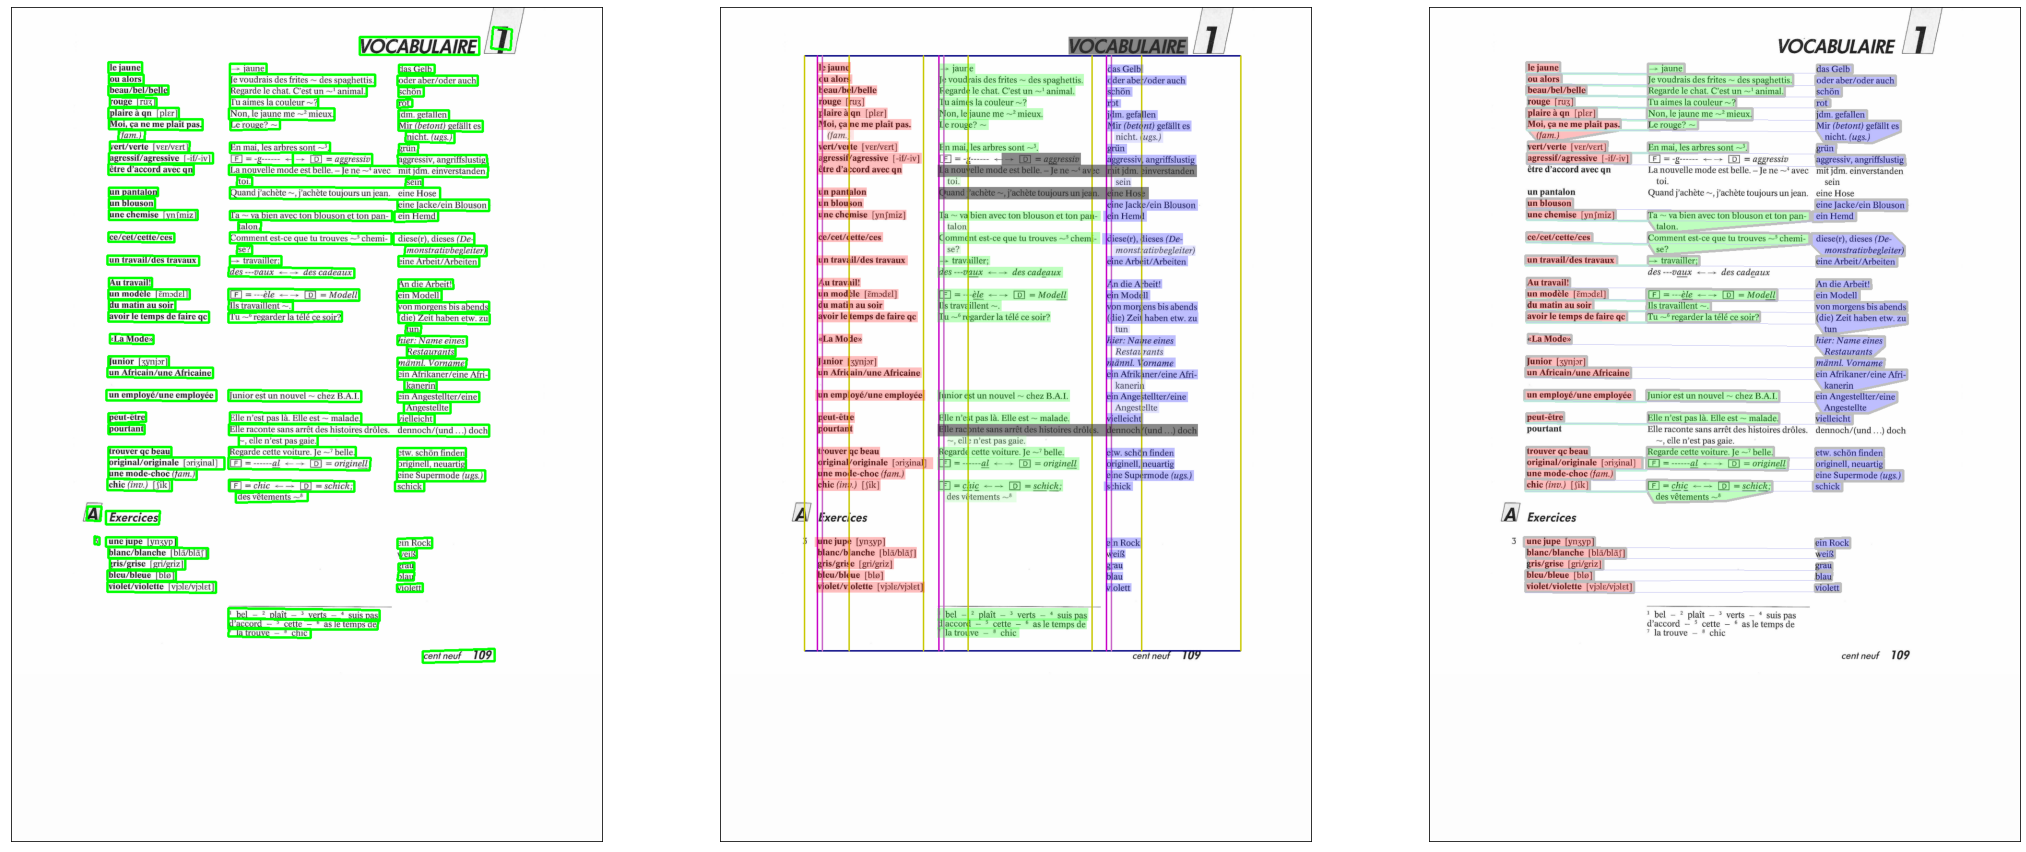

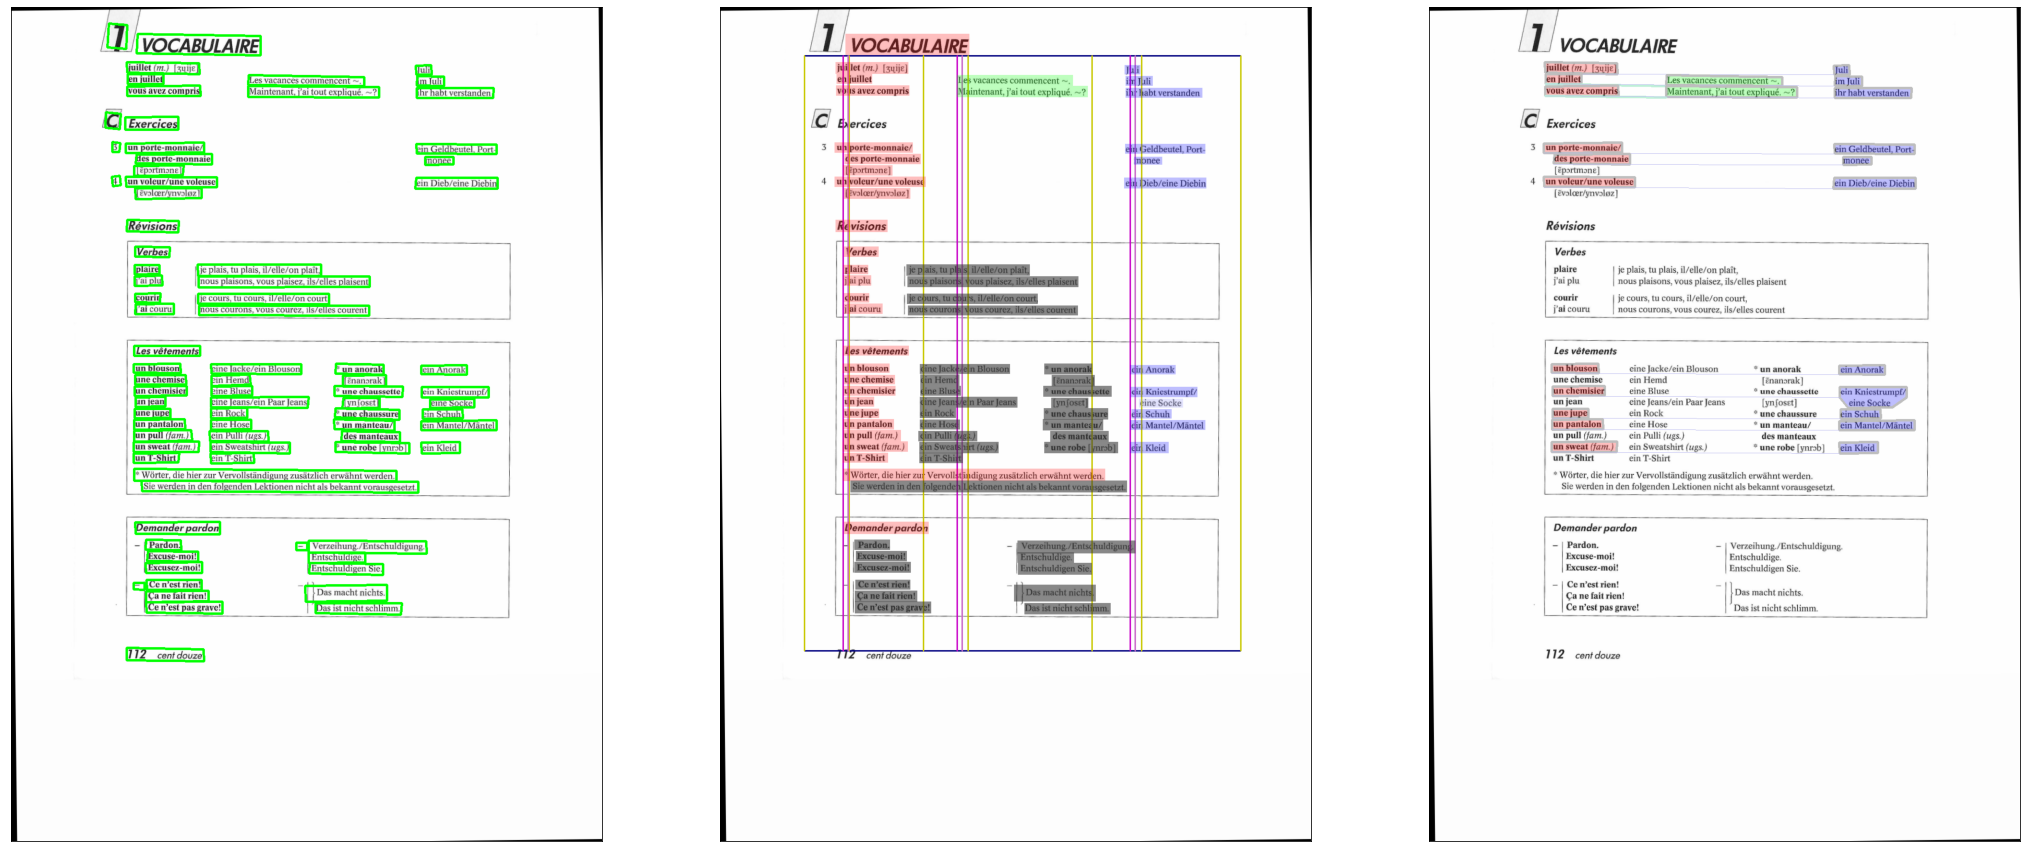

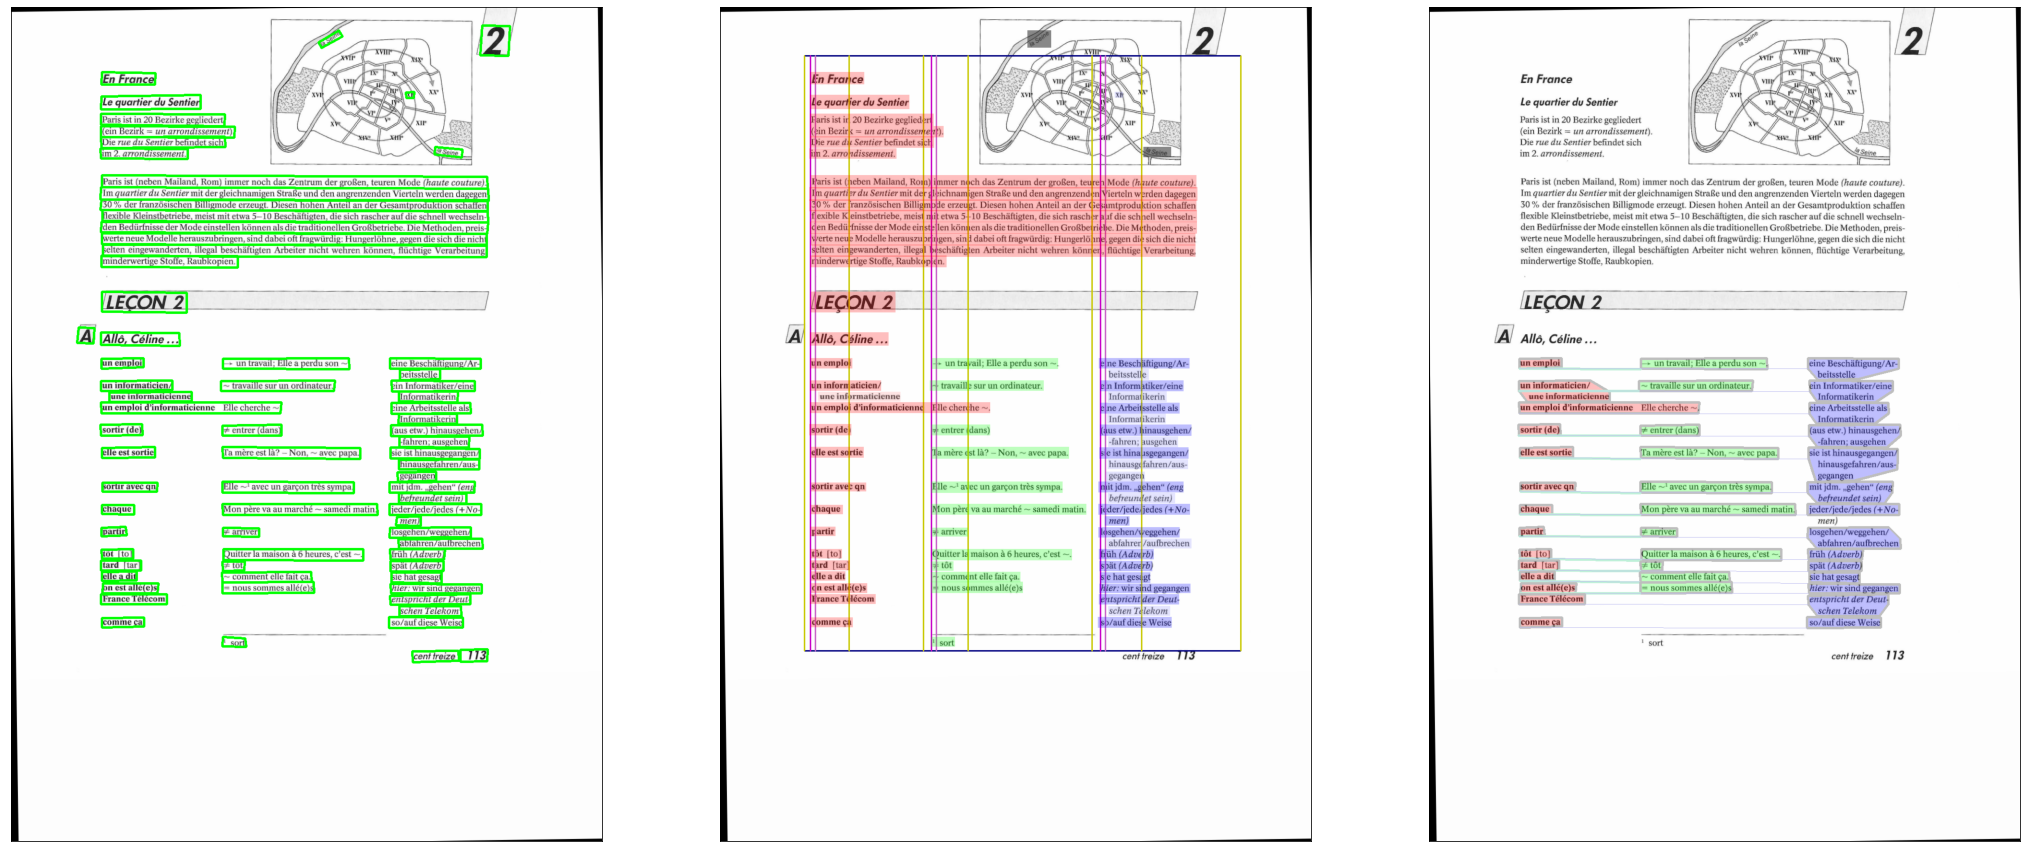

In [19]:
for i,result in enumerate(results):
    if i not in [0,3,4]:continue
    ims = [result['im'],
           result['im_language_labels'],
           result['im_hulls']]
    gridshow(ims)
